In [12]:
import torch
import torchvision
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from skimage import io
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

In [13]:
class my_net(nn.Module):
    def __init__(self):
        super(my_net, self).__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(1, 4), stride=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(in_channels=10, out_channels=30, kernel_size=(1, 3), stride=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(in_channels=30, out_channels=50, kernel_size=(1, 2), stride=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(in_channels=50, out_channels=70, kernel_size=(1, 2), stride=(1, 1)),  # New Conv Layer
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Flatten(),
            nn.Linear(1330, 1000),
            nn.ReLU(),
            nn.Linear(1000, 1)
        )
    
    def forward(self, x):
        scores = self.conv_stack(x)
        return scores

In [14]:
## Checking the availiability of cuda cores
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('GPU is available')
else:
    device = torch.device('cpu')
    print('GPU is not available')

GPU is available


In [15]:
## Hyperparms
epochs = 500
lrate = 0.0025
bsize = 32

## For reproduction purposes 
torch.manual_seed(7)

## Cost Function
cost_fn = nn.BCEWithLogitsLoss()

## Intialize the model
net = my_net()

## Optimizer (Stochastic Gradient Descent)
optimizer = torch.optim.SGD(net.parameters(), lr=lrate)

In [16]:
## Import and split the training and testing dataset
test_data = pd.read_csv(r'C:\Users\liuch\Desktop\395\Final_Project\Spaceship_Titanic\spaceship-titanic\test_data_featured.csv')

# Change this comment if you want to pick from mode imputation or knn imputation
## train_data_mode = pd.read_csv(r'C:\Users\liuch\Desktop\395\Final_Project\Spaceship_Titanic\spaceship-titanic\train_data_mode.csv')
train_data_mode = pd.read_csv(r'C:\Users\liuch\Desktop\395\Final_Project\Spaceship_Titanic\spaceship-titanic\train_data_knn.csv')

train_data_mode.drop(['PassengerId', 'Name', 'Cabin'], axis=1, inplace=True)
test_data.drop(['PassengerId', 'Name', 'Cabin'], axis=1, inplace=True)

train_mode_y = train_data_mode['Transported']
train_mode_X = train_data_mode.drop('Transported',axis=1)
test_data_y = test_data['Transported']
test_data_X = test_data.drop('Transported',axis=1)

In [17]:
# Convert Boolean Columns to Floats
for col in train_mode_X.columns:
    if train_mode_X[col].dtype == bool:
        train_mode_X[col] = train_mode_X[col].astype(float)

print(train_mode_X.dtypes)

CryoSleep                    float64
Age                          float64
VIP                          float64
RoomService                  float64
FoodCourt                    float64
ShoppingMall                 float64
Spa                          float64
VRDeck                       float64
Num                          float64
Deck_A                       float64
Deck_B                       float64
Deck_C                       float64
Deck_D                       float64
Deck_E                       float64
Deck_F                       float64
Deck_G                       float64
Deck_T                       float64
Side_P                       float64
Side_S                       float64
Destination_55 Cancri e      float64
Destination_PSO J318.5-22    float64
Destination_TRAPPIST-1e      float64
HomePlanet_Earth             float64
HomePlanet_Europa            float64
HomePlanet_Mars              float64
Cabin_encoded                float64
dtype: object


In [18]:
# Convert DataFrame to tensors
train_mode_X_tensor = torch.tensor(train_mode_X.values, dtype=torch.float32)
train_mode_X_tensor = train_mode_X_tensor.view(-1, 1, 1, 26)
train_mode_y_tensor = torch.tensor(train_mode_y.values, dtype=torch.float32)

# Create datasets
train_dataset = TensorDataset(train_mode_X_tensor, train_mode_y_tensor)

# Create DataLoader
train_loader = DataLoader(dataset=train_dataset, batch_size=bsize, shuffle=True)

In [19]:
# Train Loop
net.to(device)
net.train()
loss_history = []

for epoch in range(epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move tensors to GPU
        # Forward pass
        outputs = net(inputs)
        loss = cost_fn(outputs.squeeze(), labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    loss_history.append(epoch_loss)

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}')

Epoch [10/500], Loss: 0.5085
Epoch [20/500], Loss: 0.4956
Epoch [30/500], Loss: 0.4874
Epoch [40/500], Loss: 0.4776
Epoch [50/500], Loss: 0.4724
Epoch [60/500], Loss: 0.4673
Epoch [70/500], Loss: 0.4655
Epoch [80/500], Loss: 0.4631
Epoch [90/500], Loss: 0.4589
Epoch [100/500], Loss: 0.4575
Epoch [110/500], Loss: 0.4520
Epoch [120/500], Loss: 0.4503
Epoch [130/500], Loss: 0.4487
Epoch [140/500], Loss: 0.4482
Epoch [150/500], Loss: 0.4485
Epoch [160/500], Loss: 0.4461
Epoch [170/500], Loss: 0.4430
Epoch [180/500], Loss: 0.4391
Epoch [190/500], Loss: 0.4366
Epoch [200/500], Loss: 0.4340
Epoch [210/500], Loss: 0.4318
Epoch [220/500], Loss: 0.4284
Epoch [230/500], Loss: 0.4278
Epoch [240/500], Loss: 0.4226
Epoch [250/500], Loss: 0.4249
Epoch [260/500], Loss: 0.4179
Epoch [270/500], Loss: 0.4183
Epoch [280/500], Loss: 0.4127
Epoch [290/500], Loss: 0.4125
Epoch [300/500], Loss: 0.4114
Epoch [310/500], Loss: 0.4043
Epoch [320/500], Loss: 0.4063
Epoch [330/500], Loss: 0.4027
Epoch [340/500], Lo

In [20]:
# Convert Boolean Columns to Floats
for col in test_data_X.columns:
    if test_data_X[col].dtype == bool or test_data_X[col].dtype == object:
        test_data_X[col] = test_data_X[col].astype(float)

print(test_data_X.dtypes)

CryoSleep                    float64
Age                          float64
VIP                          float64
RoomService                  float64
FoodCourt                    float64
ShoppingMall                 float64
Spa                          float64
VRDeck                       float64
Num                          float64
Deck_A                       float64
Deck_B                       float64
Deck_C                       float64
Deck_D                       float64
Deck_E                       float64
Deck_F                       float64
Deck_G                       float64
Deck_T                       float64
Side_P                       float64
Side_S                       float64
Destination_55 Cancri e      float64
Destination_PSO J318.5-22    float64
Destination_TRAPPIST-1e      float64
HomePlanet_Earth             float64
HomePlanet_Europa            float64
HomePlanet_Mars              float64
Cabin_encoded                  int64
dtype: object


In [21]:
# Convert test data
X_test = torch.tensor(test_data_X.values, dtype=torch.float32)
y_test = torch.tensor(test_data_y.values, dtype=torch.float32)
test_dataset = TensorDataset(train_mode_X_tensor, train_mode_y_tensor)
test_loader = DataLoader(dataset=test_dataset, batch_size=bsize)

# Evaluation mode
net.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move tensors to GPU
        outputs = net(inputs)
        predicted = (outputs.squeeze() > 0).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the test samples: {100 * correct / total:.2f}%')

Accuracy of the network on the test samples: 82.68%


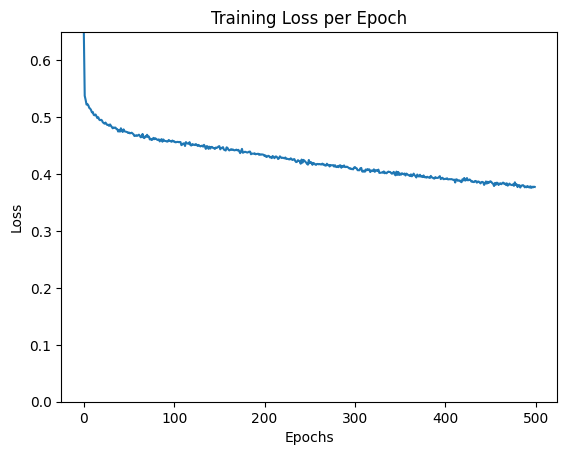

In [22]:
plt.plot(loss_history, label='Training Loss')
plt.title('Training Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, max(loss_history))
plt.show()